In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/Svm')
print("We are currently in the folder of ",os.getcwd())

We are currently in the folder of  /content/gdrive/MyDrive/Colab Notebooks/Svm


In [3]:
import glob
import os
import librosa
import librosa.display
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile
import pickle
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
convert={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fear',
  '07':'disgust',
  '08':'surprised'
}

#defined tess emotions to test on TESS dataset only
tess_emotions=['angry','disgust','fear','ps','happy','neutral' ,'sad']

##defined RAVDESS emotions to test on RAVDESS dataset only
ravdess_emotions=['neutral','calm','angry', 'happy','disgust','sad','fear','surprised']

observed_emotions = ['sad','angry','happy','disgust','surprised','neutral','calm','fear']

In [8]:
RAV="/content/gdrive/MyDrive/Colab Notebooks/RAVDESS&TESS/"

In [9]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] = RAV_df.emotion
RAV_df['source'] = 'RAVDESS&TESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
# RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

happy       592
fear        592
angry       592
sad         592
surprise    592
disgust     592
neutral     496
calm        192
Name: labels, dtype: int64

In [10]:
RAV_df.labels.count()

4240

In [11]:
RAV_df.head()

,gender,emotion,labels,source,path
0,male,calm,calm,RAVDESS&TESS,/content/gdrive/MyDrive/Colab Notebooks/RAVDES...
1,male,disgust,disgust,RAVDESS&TESS,/content/gdrive/MyDrive/Colab Notebooks/RAVDES...
2,male,neutral,neutral,RAVDESS&TESS,/content/gdrive/MyDrive/Colab Notebooks/RAVDES...
3,male,happy,happy,RAVDESS&TESS,/content/gdrive/MyDrive/Colab Notebooks/RAVDES...
4,male,disgust,disgust,RAVDESS&TESS,/content/gdrive/MyDrive/Colab Notebooks/RAVDES...


In [12]:
RAV_df=RAV_df.drop(['labels'],axis=1)

In [13]:
RAV_df.head()

,gender,emotion,source,path
0,male,calm,RAVDESS&TESS,/content/gdrive/MyDrive/Colab Notebooks/RAVDES...
1,male,disgust,RAVDESS&TESS,/content/gdrive/MyDrive/Colab Notebooks/RAVDES...
2,male,neutral,RAVDESS&TESS,/content/gdrive/MyDrive/Colab Notebooks/RAVDES...
3,male,happy,RAVDESS&TESS,/content/gdrive/MyDrive/Colab Notebooks/RAVDES...
4,male,disgust,RAVDESS&TESS,/content/gdrive/MyDrive/Colab Notebooks/RAVDES...


In [14]:
RAV_df.to_csv("/content/gdrive/MyDrive/Colab Notebooks/Svm/Data_path.csv",index=False)

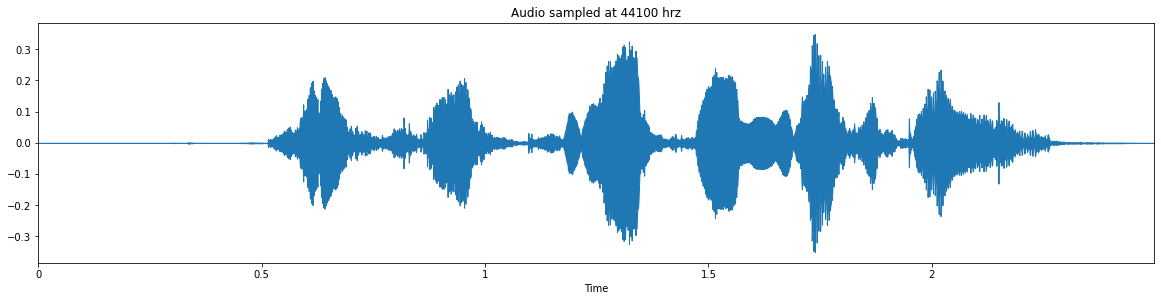

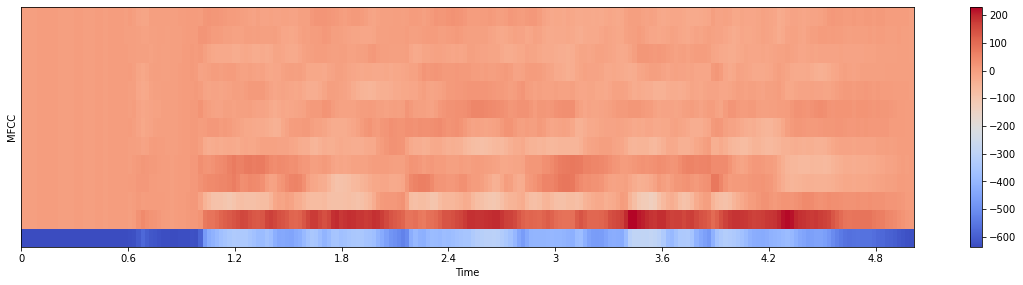

In [15]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = "/content/gdrive/MyDrive/Colab Notebooks/Dataset Ravdess&Tess/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

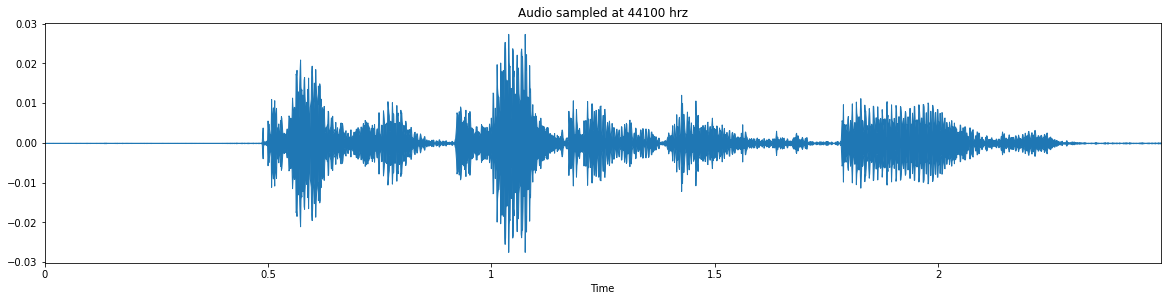

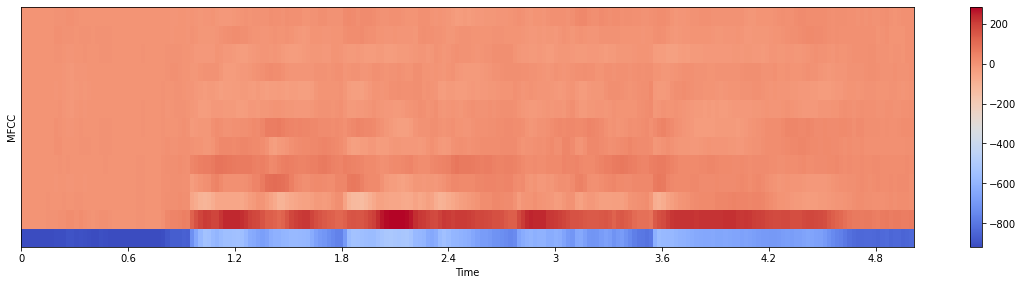

In [16]:
# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = "/content/gdrive/MyDrive/Colab Notebooks/Dataset Ravdess&Tess/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

216
216


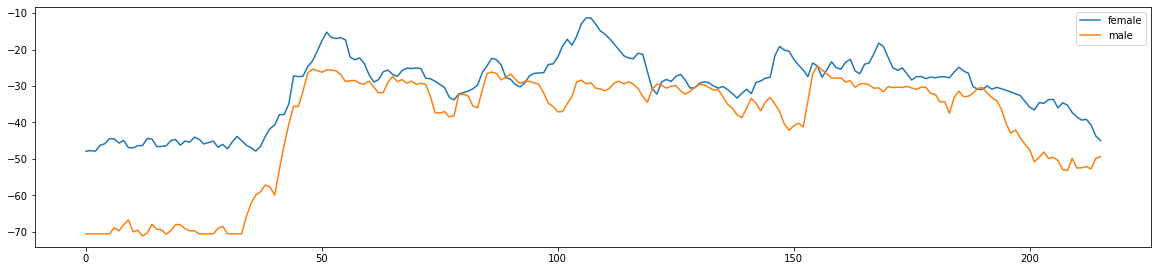

In [17]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = "/content/gdrive/MyDrive/Colab Notebooks/Dataset Ravdess&Tess/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = "/content/gdrive/MyDrive/Colab Notebooks/Dataset Ravdess&Tess/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

In [21]:
def extract_feature(file_name, mfcc):
    X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack(mfccs)
    return result

In [23]:
def load_data(test_size=0.25):
    X, y , z = [], [], []
    for file in glob.glob("/content/gdrive/MyDrive/Colab Notebooks/RAVDESS&TESS/Actor_*/*.wav"):
        # get the base name of the audio file
        basename = os.path.basename(file)

        # get the emotion label
        emotion = convert[basename.split("-")[2]]
        part = basename.split('.')[0].split('-')
        temp = int(part[6])
        if temp%2 == 00:
            temp = "female"
        else:
            temp = "male"
        # gender.append(temp)
        # we allow only AVAILABLE_EMOTIONS we set
        if emotion not in observed_emotions:
            continue
        # extract speech features
        features = extract_feature(file, mfcc=True)
        # add to data
        X.append(features)
        y.append(emotion)
        z.append(temp)
    return {"X":X,"y":y, "z":z}

In [24]:
start_time = time.time()

Trial_dict = load_data(test_size = 0.25)

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 2151.692051887512 seconds ---


In [25]:
X = pd.DataFrame(Trial_dict["X"])
y = pd.DataFrame(Trial_dict["y"],columns=['emotion'])
z = pd.DataFrame(Trial_dict["z"],columns=['gender'])

In [26]:
y

,emotion
0,sad
1,neutral
2,sad
3,neutral
4,happy
...,...
4235,sad
4236,calm
4237,calm
4238,calm


In [27]:
z

,gender
0,male
1,male
2,male
3,male
4,male
...,...
4235,male
4236,male
4237,male
4238,male


In [28]:
#renaming the label column to emotion
y=y.rename(columns= {0: 'emotion'})

In [29]:
#concatinating the attributes and label into a single dataframe
data = pd.concat([z, y, X], axis =1)

In [30]:
data[:5]

,gender,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,male,sad,-619.208496,82.765747,-16.184448,23.655073,2.373570,11.163785,5.302565,-4.864605,-7.611245,3.661317,6.279752,-1.271762,7.431250,0.290073,0.397273,1.647380,1.865108,0.138811,-1.685639,-0.422888,-2.153878,1.551158,-0.601949,0.181478,1.626723,0.837144,1.165214,0.404917,-1.655446,-3.525898,-0.820161,-0.555415,0.430852,0.970115,-1.257471,-1.522271,1.352558,1.423695,-0.961669,-1.039144
1,male,neutral,-635.191772,81.664528,-5.386692,26.374006,4.953660,11.496079,9.202490,-4.851169,-6.059440,4.492674,2.203367,-1.591004,7.515840,-1.192966,0.311319,2.673986,-0.177127,-1.578603,-0.894859,1.961766,-1.528234,0.744620,0.391248,-1.187420,0.028412,-0.763750,-0.244808,-0.583043,-1.873768,-1.085218,0.123824,-0.280311,0.748212,0.213142,-1.337872,-1.091240,-1.180558,-1.160177,-1.356111,-1.465192
2,male,sad,-567.554077,69.487160,-20.911123,22.615967,1.753074,6.676404,0.027155,-6.012868,-7.270780,4.013628,3.628860,-3.929821,7.605184,-1.005652,2.957703,2.996979,-1.223629,1.155717,-0.254367,1.634174,0.578961,1.398650,-1.614110,0.332218,1.972116,0.474554,2.310270,0.886420,-0.388400,-0.359333,0.417268,0.348086,1.844465,2.234151,0.262203,0.080054,0.784293,0.874823,1.834028,1.883987
3,male,neutral,-655.658630,81.373299,-5.377205,28.238825,6.315036,10.481622,7.297258,0.359190,-2.964392,3.033418,3.570468,-1.773483,7.500991,1.211161,1.141741,0.865980,-0.810130,-1.058006,-0.763914,2.026064,-1.931346,0.475578,-0.436374,-0.064532,0.953304,-1.510158,0.254685,-0.208165,-1.635535,-1.220779,0.550930,-0.430166,0.117324,0.234550,-1.524665,-0.006032,-0.192202,-0.542225,-0.774974,-1.246365
4,male,happy,-507.087036,55.753864,-19.819744,17.244844,-12.174647,12.134954,-8.846476,-5.765077,-6.903250,-3.585363,-0.168762,-9.547359,3.156531,-6.262373,-0.263507,-2.441354,-3.410687,1.292224,-1.595828,3.164823,3.512879,4.717840,3.482185,4.889198,5.917491,6.985015,4.042941,1.029474,1.137966,0.550859,2.287294,1.313618,2.410437,1.577121,0.706920,1.944114,1.358513,1.025472,1.861600,1.291965


In [ ]:
data.to_csv("/content/gdrive/MyDrive/Colab Notebooks/Svm/MFCC_SVM.csv",index=False)